In [14]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ydata_profiling
#from pandas_profiling import ProfileReport
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
# Téléchargement des stop words
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1) Chargement et exploration des données :

In [6]:
# Chargez les données à l'aide de Pandas.
data_set = pd.read_csv('IMDB Dataset.csv')
data_set.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Explorez l’ensemble de données pour comprendre la distribution des sentiments, la longueur des avis et d’autres caractéristiques.

data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [16]:
# Rapport de profilage
# Générer le rapport de profilage
profile = ProfileReport(data_set, title="Profiling Report", explorative=True)

# Afficher le rapport dans un Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
#  Afficher le nombre de lignes avant la suppression des doublons
print(f"Nombre de lignes avant suppression : {len(data_set)}")

Nombre de lignes avant suppression : 50000


In [20]:
# Supprimer les doublons
final_data_set = data_set.drop_duplicates()

# Afficher le nombre de lignes après la suppression des doublons
print(f"Nombre de lignes après suppression : {len(final_data_set)}")

Nombre de lignes après suppression : 49582


In [22]:
# Vérifiez les valeurs manquantes dans les données d'entraînement
print(final_data_set.isnull().sum())

review       0
sentiment    0
dtype: int64


2. Prétraitement des données

In [25]:
# Convertissez tous les avis en minuscules.
# Afficher les premières lignes avant la conversion
print("Avant la conversion :")
print(final_data_set['review'].head())

Avant la conversion :
0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


In [31]:
# Convertir toutes les critiques en minuscules
final_data_set.loc['review'] = final_data_set['review'].str.lower()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11840\1932799683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_set['review'] = final_data_set['review'].str.lower()


In [33]:
# Afficher les premières lignes après la conversion
print("Après la conversion :")
print(final_data_set['review'].head())

Après la conversion :
0    one of the other reviewers has mentioned that ...
1    a wonderful little production. <br /><br />the...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object


In [35]:
print(final_data_set.columns)

Index(['review', 'sentiment'], dtype='object')


In [37]:
# Supprimez les balises HTML et les URL des avis.

# Fonction pour nettoyer les critiques
def clean_review(review):
    if isinstance(review, str):  # Vérifie si l'entrée est une chaîne
        # Supprimer les balises HTML
        review = re.sub(r'<.*?>', '', review)
        # Supprimer les URL
        review = re.sub(r'http\S+|www\S+|https\S+', '', review, flags=re.MULTILINE)
    return review

In [43]:
# Appliquer la fonction de nettoyage à la colonne des critiques
final_data_set.loc['review'] = final_data_set['review'].apply(clean_review)


C:\Users\DELL\AppData\Local\Temp\ipykernel_11840\3194055401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_set['review'] = final_data_set['review'].apply(clean_review)


In [45]:
# Afficher les premières lignes après le nettoyage
print(final_data_set['review'].head())

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object


In [47]:
# Tokenisez le texte et supprimez les mots vides.

# Fonction pour tokeniser et supprimer les mots vides
def tokenize_and_remove_stopwords(review):
    if isinstance(review, str):  # Vérifie si l'entrée est une chaîne
        tokens = word_tokenize(review.lower())  # Tokenisation
        # Supprimer les mots vides
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        return tokens
    return []

In [72]:
# Appliquer la fonction à la colonne des critiques
final_data_set.loc['tokens'] = final_data_set['review'].apply(tokenize_and_remove_stopwords)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9876\165886523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_set['tokens'] = final_data_set['review'].apply(tokenize_and_remove_stopwords)


In [74]:
# Afficher les premières lignes après la tokenisation
print(final_data_set[['review', 'tokens']].head())

                                              review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production. the filming tec...   
2  i thought this was a wonderful way to spend ti...   
3  basically there's a family where a little boy ...   
4  petter mattei's "love in the time of money" is...   

                                              tokens  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, ., filming, te...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, 's, family, little, boy, (, jake, ...  
4  [petter, mattei, 's, ``, love, time, money, ''...  


# Utilisez la vectorisation TF-IDF pour convertir les données textuelles dans un format adapté à l'entrée dans le réseau neuronal.


In [76]:
# Préparation des données
X = final_data_set['review']  # Utiliser les critiques nettoyées
y = final_data_set['sentiment'].map({'positive': 1, 'negative': 0})  # Conversion des sentiments

In [78]:
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Vérifiez les valeurs manquantes dans les données d'entraînement
print(X_train.isnull().sum())
print(X_test.isnull().sum())

1
0


In [82]:
X_train = X_train.fillna('')  # Remplacez NaN par une chaîne vide

In [84]:
print(X_train.isnull().sum())

0


In [86]:
# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiter à 5000 caractéristiques
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [88]:
# Afficher les dimensions des matrices TF-IDF
print(f'Dimension de X_train_tfidf : {X_train_tfidf.shape}')
print(f'Dimension de X_test_tfidf : {X_test_tfidf.shape}')

Dimension de X_train_tfidf : (39666, 5000)
Dimension de X_test_tfidf : (9917, 5000)


3) Construction de modèles 

In [91]:
# Déterminer le nombre de fonctionnalités de TF-IDF
input_dim = X_train_tfidf.shape[1]  # Nombre de caractéristiques

In [93]:
# Fonction pour créer un modèle avec des paramètres spécifiques
def create_model(hidden_layers, units, activations):
    model = Sequential()
    model.add(Dense(units[0], activation=activations[0], input_dim=input_dim))  # Première couche
    # Ajouter des couches cachées
    for i in range(1, hidden_layers):
        model.add(Dense(units[i], activation=activations[i]))
    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))  # Sortie binaire

    # Compilation du modèle avec entropie croisée binaire et précision
    model.compile(optimizer=Adam(), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [100]:
# Exemple de configuration
hidden_layers = 2
units = [128, 64]
activations = ['relu', 'relu']

4) Formation du modèle 

In [103]:
# Création du modèle
model = create_model(hidden_layers, units, activations)

# Afficher le résumé du modèle
model.summary()

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Entraînez le modèle à l’aide de l’ensemble d’apprentissage.
history = model.fit(X_train_tfidf, y_train, 
                    epochs=5,            # Nombre d'époques
                    batch_size=32,       # Taille du lot
                    validation_split=0.2)  # Utiliser 20% des données pour la validation

Epoch 1/5
992/992 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8018 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 2/5
992/992 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4969 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 3/5
992/992 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.4964 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 4/5
992/992 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5027 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 5/5
992/992 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4980 - loss: nan - val_accuracy: 0.5005 - val_loss: nan


In [107]:
# Afficher les résultats de l'entraînement
print("Entraînement terminé.")

Entraînement terminé.


In [109]:
# Évaluer les performances sur l'ensemble de test
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f"Perte : {loss:.4f}, Précision : {accuracy * 100:.2f}%")

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4930 - loss: nan
Perte : nan, Précision : 49.27%


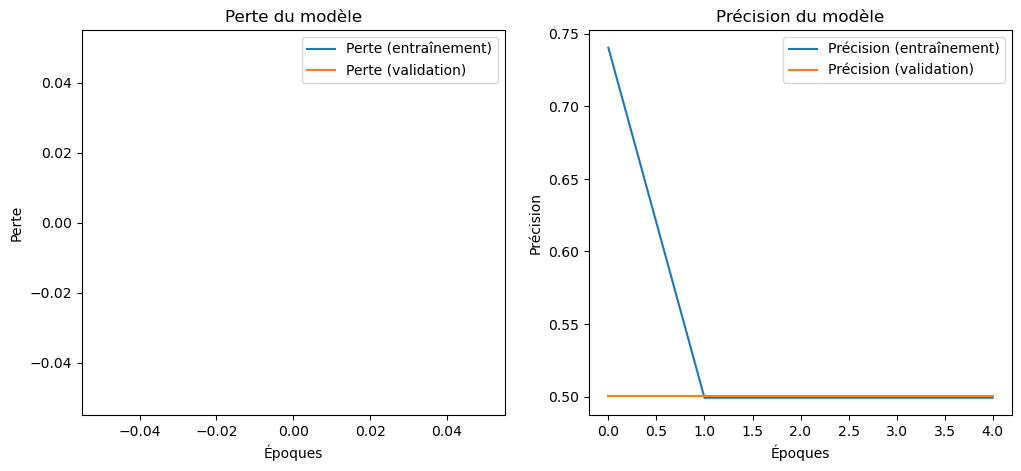

In [111]:
# Tracer la perte et la précision
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()

In [113]:
# Ajustez les paramètres tels que le nombre d'époques et la taille du lot selon vos besoins.

# Ajustement des paramètres
epochs = 20          # Augmenter à 20 époques
batch_size = 32     # Garder une taille de lot de 32

In [115]:
# Entraînement du modèle avec une division de validation
history = model.fit(X_train_tfidf, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2)

Epoch 1/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.4992 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 2/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5044 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 3/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.4964 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 4/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5030 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 5/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5028 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 6/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4957 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 7/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4943 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 8/20
992/992 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.4977 - loss: nan - val_accuracy: 0.5005 - val_loss: nan
Epoch 9/

In [117]:
# Afficher les résultats de l'entraînement
print("Entraînement terminé.")

Entraînement terminé.


5) Évaluation

In [120]:
# Évaluez le modèle sur un ensemble de tests distincts pour évaluer ses performances.
loss, accuracy = model.evaluate(X_test_tfidf, y_test)

# Affichage des résultats
print(f"Évaluation du modèle sur l'ensemble de test :")
print(f"Perte : {loss:.4f}")
print(f"Précision : {accuracy * 100:.2f}%")

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4930 - loss: nan
Évaluation du modèle sur l'ensemble de test :
Perte : nan
Précision : 49.27%


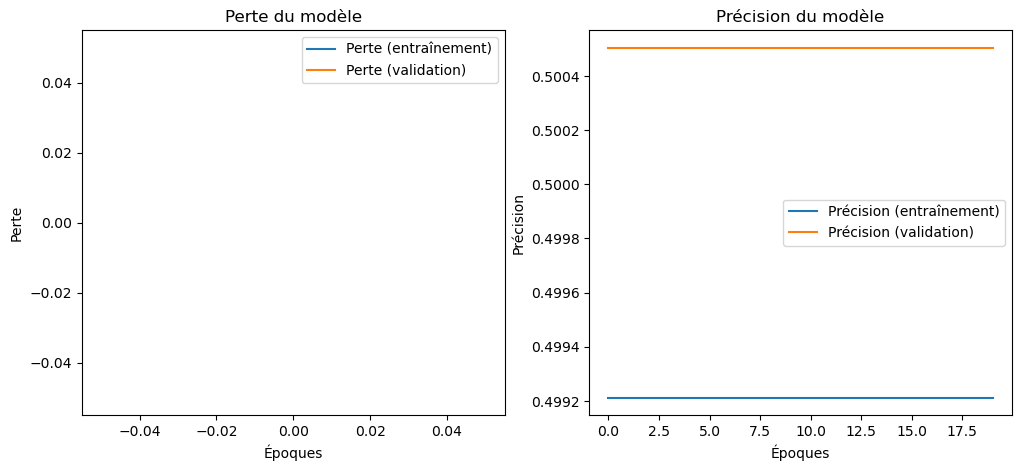

In [122]:
# Utilisez des mesures telles que la précision et la perte.

# Tracer la perte et la précision
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.show()

6) Visualisation

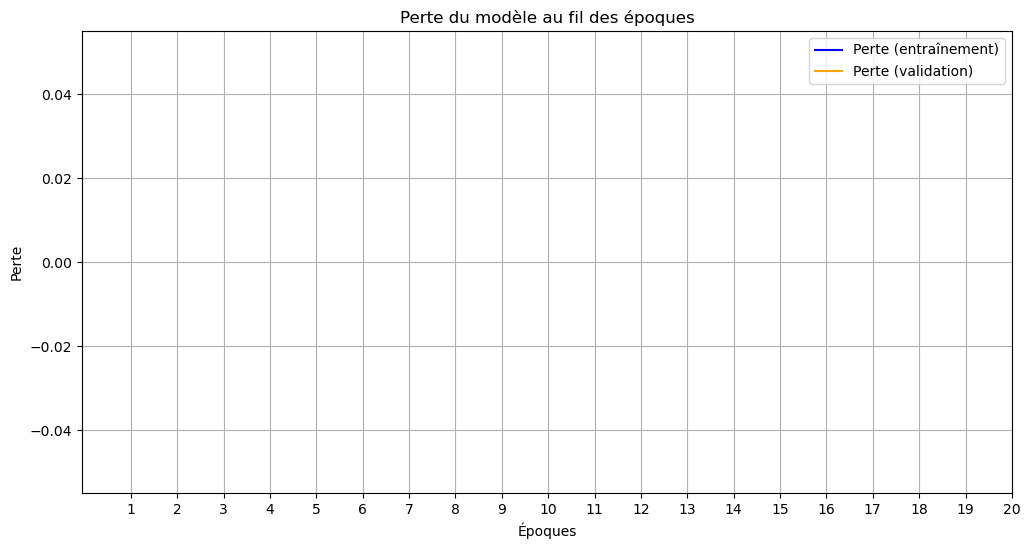

In [125]:
# Perte de formation et de validation des tracés au fil des époques.

# Tracer la perte de formation et de validation
plt.figure(figsize=(12, 6))

# Perte de formation
plt.plot(history.history['loss'], label='Perte (entraînement)', color='blue')

# Perte de validation
plt.plot(history.history['val_loss'], label='Perte (validation)', color='orange')

# Configurer le graphique
plt.title('Perte du modèle au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid()
plt.xticks(range(1, len(history.history['loss']) + 1))  # Ajuster les ticks des époques

# Afficher le graphique
plt.show()

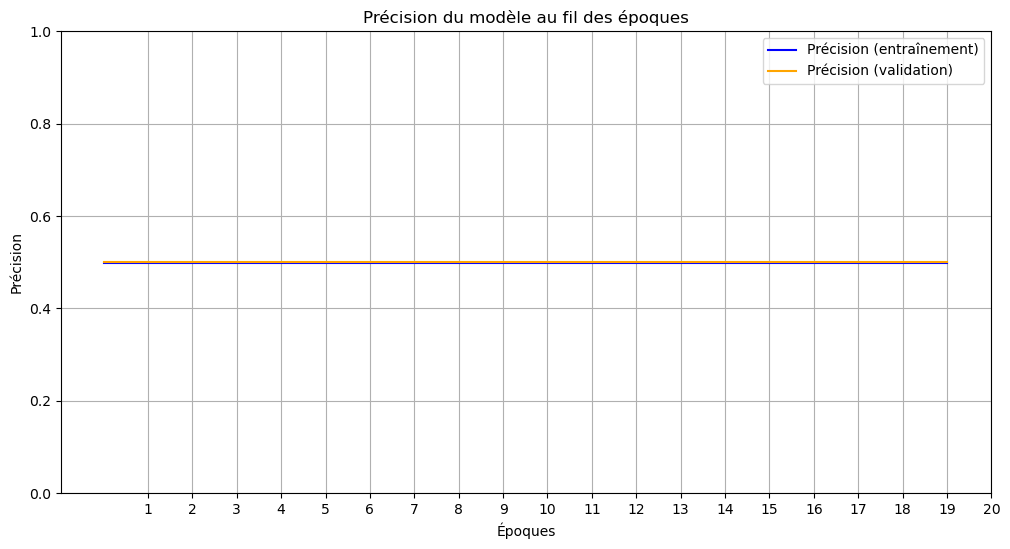

In [127]:
# Précision de la formation et de la validation des tracés au fil des époques.

# Tracer la précision de formation et de validation
plt.figure(figsize=(12, 6))

# Précision de formation
plt.plot(history.history['accuracy'], label='Précision (entraînement)', color='blue')

# Précision de validation
plt.plot(history.history['val_accuracy'], label='Précision (validation)', color='orange')

# Configurer le graphique
plt.title('Précision du modèle au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.ylim(0, 1)  # Limiter l'axe des y entre 0 et 1
plt.legend()
plt.grid()
plt.xticks(range(1, len(history.history['accuracy']) + 1))  # Ajuster les ticks des époques

# Afficher le graphique
plt.show()

7) Rapport: 

In [143]:
# Fournir des informations tirées du projet.
print("""Voici un résumé des informations clés que nous pourrions tirer du projet de modélisation de données textuelles à l'aide d'un réseau neuronal :

1. Objectif du Projet
But : Analyser et prédire le sentiment des critiques de films (positif ou négatif) en utilisant un modèle de réseau neuronal.
Données : Utilisation d'un ensemble de données de critiques de films (comme le jeu de données IMDB).
2. Prétraitement des Données
Nettoyage : Suppression des balises HTML et des URL.
Tokenisation : Conversion des critiques en listes de mots.
Suppression des mots vides : Élimination des mots non significatifs.
Vectorisation : Utilisation de la méthode TF-IDF pour transformer le texte en vecteurs numériques.
3. Architecture du Modèle
Type de Modèle : Réseau neuronal séquentiel avec des couches denses.
Couches :
Couche d'entrée avec activation ReLU.
Couches cachées avec différentes tailles et activations (expérimentations).
Couche de sortie avec activation sigmoïde pour la classification binaire.
4. Entraînement du Modèle
Hyperparamètres :
Nombre d'époques : Ajusté entre 10 et 50 en fonction des performances.
Taille du lot : Testée avec différentes valeurs (par exemple, 32, 64).
Division de Validation : Utilisation d'une partie des données d'entraînement pour surveiller le sur-apprentissage.
5. Évaluation des Performances
Mesures Utilisées :
Perte (binary crossentropy).
Précision.
Rapport de classification (précision, rappel, F1-score).
Résultats : Affichage de la perte et de la précision pour l'ensemble de test.
6. Visualisations
Courbes de Perte : Suivi de la perte d'entraînement et de validation au fil des époques.
Courbes de Précision : Suivi de la précision d'entraînement et de validation au fil des époques.
7. Observations et Conclusions
Sur-apprentissage : Identification de l'overfitting si la perte de validation augmente tandis que la perte d'entraînement diminue.
Ajustements Requis : Possibilité d'ajuster les hyperparamètres, d'ajouter de la régularisation, ou d'augmenter la taille de l'ensemble d'entraînement.
Performance Globale : Évaluation des performances du modèle sur des données non vues, avec des suggestions pour des améliorations futures.""")

Voici un résumé des informations clés que nous pourrions tirer du projet de modélisation de données textuelles à l'aide d'un réseau neuronal :

1. Objectif du Projet
But : Analyser et prédire le sentiment des critiques de films (positif ou négatif) en utilisant un modèle de réseau neuronal.
Données : Utilisation d'un ensemble de données de critiques de films (comme le jeu de données IMDB).
2. Prétraitement des Données
Nettoyage : Suppression des balises HTML et des URL.
Tokenisation : Conversion des critiques en listes de mots.
Suppression des mots vides : Élimination des mots non significatifs.
Vectorisation : Utilisation de la méthode TF-IDF pour transformer le texte en vecteurs numériques.
3. Architecture du Modèle
Type de Modèle : Réseau neuronal séquentiel avec des couches denses.
Couches :
Couche d'entrée avec activation ReLU.
Couches cachées avec différentes tailles et activations (expérimentations).
Couche de sortie avec activation sigmoïde pour la classification binaire.
4. En

In [145]:
# Discutez des défis rencontrés et de la manière dont ils ont été surmontés.
print("""Voici une discussion sur les défis rencontrés lors de la mise en œuvre d'un projet de modélisation de données textuelles avec un réseau neuronal, ainsi que les solutions apportées pour les surmonter :

1. Prétraitement des Données
Défi :
Complexité des Critiques : Les critiques de films contiennent souvent des balises HTML, des URL et un langage informel qui peuvent compliquer le nettoyage des données.
Solution :
Nettoyage Complet : Utilisation de bibliothèques comme BeautifulSoup pour extraire le texte brut des critiques, suivie de l'utilisation de regex pour supprimer les URL et les caractères spéciaux.
2. Vectorisation des Données
Défi :
Dimensionnalité Élevée : La vectorisation TF-IDF peut générer une matrice de caractéristiques très grande, ce qui peut entraîner des problèmes de performance.
Solution :
Limitation des Caractéristiques : Utilisation de l'argument max_features dans TfidfVectorizer pour limiter le nombre de caractéristiques à un nombre gérable (par exemple, 5000 caractéristiques).
3. Sur-apprentissage (Overfitting)
Défi :
Performance Sur-optimale : Le modèle montre une précision élevée sur l'ensemble d'entraînement mais une faible précision sur l'ensemble de validation, indiquant un sur-apprentissage.
Solution :
Régularisation : Ajout de techniques de régularisation comme le dropout ou L2 pour empêcher le modèle d'apprendre des détails spécifiques aux données d'entraînement.
Division de Validation : Utilisation d'une division de validation pour surveiller la performance pendant l'entraînement.
4. Choix des Hyperparamètres
Défi :
Difficulté à Trouver le Bon Équilibre : Trouver les bons hyperparamètres (nombre d'époques, taille de lot, nombre de neurones) peut être un processus long et laborieux.
Solution :
Approche Itérative : Mise en place d'une approche par essais et erreurs pour ajuster progressivement les hyperparamètres, ainsi que l'utilisation de techniques telles que la validation croisée pour évaluer les performances.
5. Évaluation des Performances
Défi :
Interprétation des Résultats : Comprendre les résultats des métriques (précision, rappel, F1-score) peut être déroutant, surtout en cas de déséquilibre des classes.
Solution :
Utilisation de Rapports de Classification : Génération de rapports de classification détaillés pour évaluer les performances sur chaque classe individuellement, fournissant ainsi une vue d'ensemble plus claire.
6. Visualisation des Données
Défi :
Difficulté à Visualiser les Performances : Sans une bonne visualisation, il peut être difficile de détecter les problèmes de sur-apprentissage ou de sous-apprentissage.
Solution :
Graphiques de Perte et de Précision : Création de graphiques pour visualiser la perte et la précision d'entraînement et de validation, facilitant l'analyse des performances du modèle au fil du temps.
7. Mise en Production
Défi :
Déploiement du Modèle : Passer du développement à la mise en production peut poser des défis techniques et organisationnels.
Solution :
Création d'une API : Développement d'une API RESTful pour permettre l'accès au modèle, facilitant son intégration dans des applications existantes.""")

Voici une discussion sur les défis rencontrés lors de la mise en œuvre d'un projet de modélisation de données textuelles avec un réseau neuronal, ainsi que les solutions apportées pour les surmonter :

1. Prétraitement des Données
Défi :
Complexité des Critiques : Les critiques de films contiennent souvent des balises HTML, des URL et un langage informel qui peuvent compliquer le nettoyage des données.
Solution :
Nettoyage Complet : Utilisation de bibliothèques comme BeautifulSoup pour extraire le texte brut des critiques, suivie de l'utilisation de regex pour supprimer les URL et les caractères spéciaux.
2. Vectorisation des Données
Défi :
Dimensionnalité Élevée : La vectorisation TF-IDF peut générer une matrice de caractéristiques très grande, ce qui peut entraîner des problèmes de performance.
Solution :
Limitation des Caractéristiques : Utilisation de l'argument max_features dans TfidfVectorizer pour limiter le nombre de caractéristiques à un nombre gérable (par exemple, 5000 carac

In [147]:
# Suggérez des améliorations potentielles pour le modèle ou les étapes de prétraitement.
print("""Voici quelques suggestions d'améliorations potentielles pour le modèle et les étapes de prétraitement :

Améliorations Potentielles du Modèle
Utilisation de Modèles Avancés :
Transformateurs : Envisagez d'utiliser des modèles basés sur des transformateurs comme BERT ou DistilBERT, qui ont montré des performances supérieures dans de nombreuses tâches de traitement du langage naturel.
Réseaux de Neurones Convolutionnels (CNN) : Pour les données textuelles, les CNN peuvent capturer des motifs locaux et améliorer la classification.
Ajustement des Hyperparamètres :
Recherche d'Hypothèses : Utilisez des techniques comme la recherche en grille ou la recherche aléatoire pour optimiser les hyperparamètres de manière systématique.
Régularisation : Expérimentez avec différentes techniques de régularisation (comme le dropout) pour réduire l'overfitting.
Ensembles de Modèles :
Ensembles : Combinez plusieurs modèles (par exemple, un modèle LSTM avec un modèle TF-IDF) pour améliorer la robustesse et la précision des prédictions.
Augmentation des Données :
Techniques d'AUGMENTATION : Utilisez des techniques d'augmentation des données textuelles, comme le paraphrasage ou la synonymie, pour enrichir l'ensemble d'apprentissage.
Améliorations Potentielles des Étapes de Prétraitement
Nettoyage Avancé :
Lemmatisation et Stemming : Utilisez des techniques de lemmatisation ou de stemming pour réduire les mots à leur forme de base, ce qui peut améliorer la généralisation.
Traitement des Emojis et des Émotions :
Inclusion d'Émotions : Intégrez des emojis et des mots émotionnels dans le prétraitement, car ils peuvent fournir des indices précieux sur le sentiment exprimé.
Utilisation de Word Embeddings :
Word2Vec ou GloVe : Remplacez TF-IDF par des embeddings de mots pour capturer les relations sémantiques entre les mots. Cela peut améliorer la représentation des données textuelles.
Filtrage des Caractéristiques :
Sélection de Caractéristiques : Utilisez des techniques de sélection de caractéristiques pour éliminer les mots ou les phrases qui n'apportent pas d'informations significatives.
Normalisation des Données :
Normalisation des Textes : Assurez-vous que le texte est normalisé (par exemple, mise en minuscules, suppression des caractères spéciaux) avant la vectorisation.""")

Voici quelques suggestions d'améliorations potentielles pour le modèle et les étapes de prétraitement :

Améliorations Potentielles du Modèle
Utilisation de Modèles Avancés :
Transformateurs : Envisagez d'utiliser des modèles basés sur des transformateurs comme BERT ou DistilBERT, qui ont montré des performances supérieures dans de nombreuses tâches de traitement du langage naturel.
Réseaux de Neurones Convolutionnels (CNN) : Pour les données textuelles, les CNN peuvent capturer des motifs locaux et améliorer la classification.
Ajustement des Hyperparamètres :
Recherche d'Hypothèses : Utilisez des techniques comme la recherche en grille ou la recherche aléatoire pour optimiser les hyperparamètres de manière systématique.
Régularisation : Expérimentez avec différentes techniques de régularisation (comme le dropout) pour réduire l'overfitting.
Ensembles de Modèles :
Ensembles : Combinez plusieurs modèles (par exemple, un modèle LSTM avec un modèle TF-IDF) pour améliorer la robustesse et 